# Neural Networks - Predicting Written Text

Using a dataset built into the Sci-kit learn library, this project will look at different classification models (mainly K-Neighbors classification and Neural Networks) that can be used to identify (predict) handwritten numbers. We will run these models and compare them to ascertain which is the most accurate. Although we hyhpothesize that the highest accuracy will come from the neural network model, we seek to explicitly demonstrate that this is the case. 

We will begin by importing all relevant modules and functions. We will then import the relevant dataset from the Sci-kit Learn library and convert the data and labels (target column) into dataframes so that we can work with the data.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

digits_data = load_digits()

digits_data.keys()


dict_keys(['DESCR', 'images', 'data', 'target', 'target_names'])

In [2]:
labels = pd.Series(digits_data['target'])


features = pd.DataFrame(digits_data['data'])

Now that we have organized the data into a workable format, for the sake of highlighting how the dataset works, we will reverse engineer some rows into their handwritten numbers by reshaping the certain rows and plotting their values. This is to demonstrate how the features columns are essentially values for pixels in a plain.

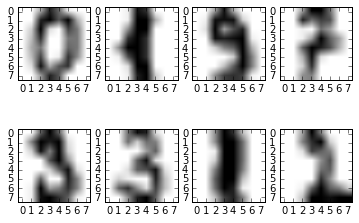

In [3]:
%matplotlib inline

f, axarr = plt.subplots(2,4)

axarr[0,0].imshow(features.iloc[0].values.reshape(8,8), cmap = 'gray_r')
axarr[0,1].imshow(features.iloc[99].values.reshape(8,8), cmap = 'gray_r')
axarr[0,2].imshow(features.iloc[199].values.reshape(8,8), cmap = 'gray_r')
axarr[0,3].imshow(features.iloc[299].values.reshape(8,8), cmap = 'gray_r')
axarr[1,0].imshow(features.iloc[399].values.reshape(8,8), cmap = 'gray_r')
axarr[1,1].imshow(features.iloc[999].values.reshape(8,8), cmap = 'gray_r')
axarr[1,2].imshow(features.iloc[1199].values.reshape(8,8), cmap = 'gray_r')
axarr[1,3].imshow(features.iloc[1299].values.reshape(8,8), cmap = 'gray_r')

## K Neighbors Classification

Our first model to be used for the written text prediction will be the KNeighbors model

In [4]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def train(train_features, train_target, k_no):
    k = KNeighborsClassifier(k_no)
    k.fit(train_features, train_target)
    return k

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_labels'] = test_labels
    train_test_df['predictions'] = predictions
    test_accuracy = sum(train_test_df['correct_labels'] == train_test_df['predictions'])/len(train_test_df)
    return test_accuracy

def cross_validate(k, attributes, target):
    fold_accuracies = []
    kf = KFold(n_splits = 4, shuffle = True, random_state = 1)
    for train_index, test_index in kf.split(attributes):
        train_features, test_features = attributes.loc[train_index], attributes.loc[test_index]
        train_labels, test_labels = target.loc[train_index], target.loc[test_index]
        model = train(train_features, train_labels, k)
        accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies
                                
errors = cross_validate(5, features, labels)
k5_error_mean = np.mean(errors)
print(errors)
print()
print(k5_error_mean)
                            

[0.9933333333333333, 0.9710467706013363, 0.9866369710467706, 0.9821826280623608]

0.9832999257609502


Now that we have the pipeline up and running we can see that we have achieved quite a low error, with prediction accuracy seemingly around 98.4%. We ran our first model using a k value of 5 (using 5 similar neghbors to make predictions). We will now see what the model looks like with a range of k_values between 1 and 10. We will then plot the results:

{1: 0.9827456075228903, 2: 0.9805184360306854, 3: 0.9855283345706509, 4: 0.9849690670626082, 5: 0.9832999257609502, 6: 0.9805159613956941, 7: 0.9821863400148477, 8: 0.9816295471417965, 9: 0.9788468200940361}


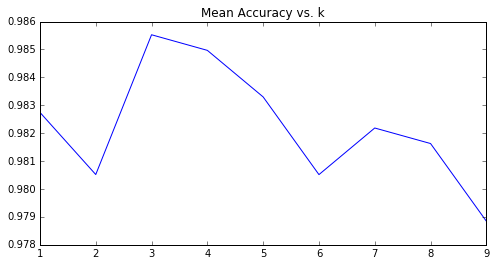

In [5]:
k_vals = list(range(1,10))
accuracies_by_k = []
k_accuracies = {}

for k in k_vals:
    accuracies = cross_validate(k, features, labels)
    mean_accuracy = np.mean(accuracies)
    accuracies_by_k.append(mean_accuracy)
    k_accuracies[k] = mean_accuracy
    
print(k_accuracies)
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. k")
plt.plot(k_vals, accuracies_by_k)

It would appear that model accuracy is maximised at a **k_value of 3**

## Neural Networks

Although we achieved quite good results using the KNeighbors model, there are some downsides to this approach. First and foremost is that this model has high memory usage, meaning that for each new unseen observation, there are many comparisons that must be made to seen observations. Secondly, there is no tangible model represenation that we are able to debug and explore.

We now move on to attempting top use a deep learning model to see if it outperforms the K-neighbors model. In this segment we will train and test models (with cross validation), all with a single hidden layer and with 8, 16, 32, 64, 128 and 256 neurons seperately. We will do this using the Sigmoid function as the activation function.

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

def train(train_features, train_target, n):
    mlp = MLPClassifier(hidden_layer_sizes = n , activation = 'logistic', max_iter = 250, solver = 'lbfgs')
    mlp.fit(train_features, train_target)
    return mlp

def test(model, test_features, test_target):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['actual'] = test_target
    train_test_df['predicted'] = predictions
    test_accuracy = sum(train_test_df['predicted'] == train_test_df['actual'])/len(train_test_df)
    return test_accuracy

def cross_validate(features, target, n):
    accuracies = {}
    validation_accuracies = []
    train_accuracies = []
    kf = KFold(n_splits = 4, shuffle = True, random_state = 2)
    for test_index, train_index in kf.split(features):
        train_features, test_features = features.loc[train_index], features.loc[test_index]
        test_labels, train_labels = target.loc[test_index], target.loc[train_index]
        model = train(train_features, train_labels, n)        
        test_accuracy = test(model, test_features, test_labels)
        train_accuracy = test(model, train_features, train_labels)
        validation_accuracies.append(test_accuracy)
        train_accuracies.append(train_accuracy)
    accuracies[train] = train_accuracies
    accuracies[test] = validation_accuracies
    return accuracies
    
testing = cross_validate(features, labels, 128)

print(testing[test])
print(testing[train])

[0.9569413511507052, 0.9146884272997032, 0.9384272997032641, 0.9369436201780416]
[1.0, 1.0, 1.0, 1.0]


In order to determine the strength of the modesl at each hidden layer neuron value, we made predictions on both the test set and the training set. These predictions were then stored seperately in a dictionary under the keys 'test' and 'train' respectively.

(0, 1)

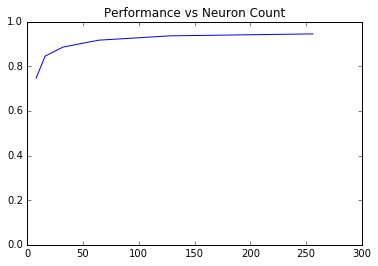

In [7]:
neurons = [(8,),(16,),(32,),(64,),(128,),(256,)]
performance_test = []

for n in neurons:
    accuracies = cross_validate(features, labels, n)
    accuracy_test = np.mean(accuracies[test])
    performance_test.append(accuracy_test)
    
##Plotting model acccuracy against the number of neaurons included in the first layer

plt.figure()
plt.title('Performance vs Neuron Count')
plt.plot(neurons, performance_test) ## Plotted as neurons (x) against prediction accuracy (y)
plt.ylim(0,1)    
    


## Neural Network Performance By Neurons in 1 Hidden Layer

As is evident by the graphic displayed above, it seems that as we increase the number of neurons in one hidden layer the accuracy of the model improves at a diminishing rate. This implies that adding more neurons increases the accuracy of a neural network model. Although, it must be stated that the returns achieved by adding more neurons diminish the more neurons we add, implying that we are reaching a point where the addition of more neurons in the seond layer is moot.

## Overfitting/Underfitting in a model with only one layer of hidden neurons

We will now attempt to discern at what number of neurons in a model with one hidden layer do we see either and or overfitting and underfitting. To determine this we will plot the accuracies of a model tested on the test_set against the saqme model tested on the training set that was used to fit it. We will illustrate this at each of the above stipulated number of hidden neaurons to determine at which point we see the model underfit/overfit.

Mean accuracy at 8 neurons: 0.6197185910441712
Mean accuracy at 16 neurons: 0.8506832691176568
Mean accuracy at 32 neurons: 0.8968632073913014
Mean accuracy at 64 neurons: 0.9182008761089046
Mean accuracy at 128 neurons: 0.9393446861803016
Mean accuracy at 256 neurons: 0.9499187941551619


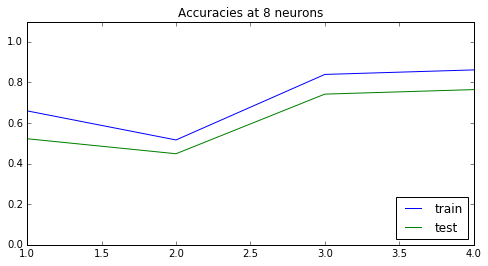

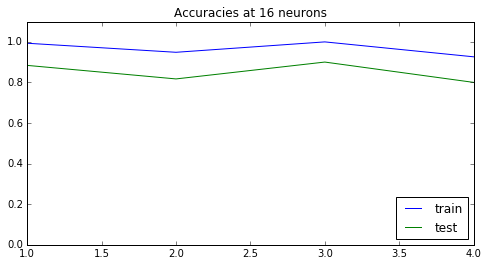

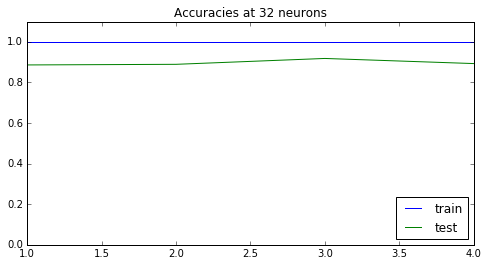

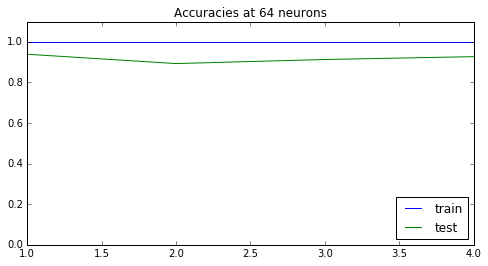

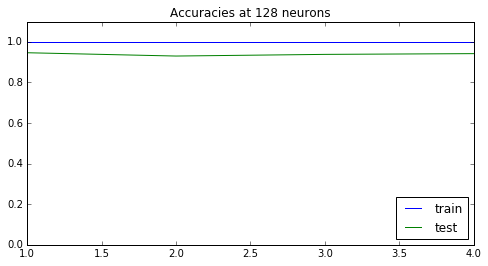

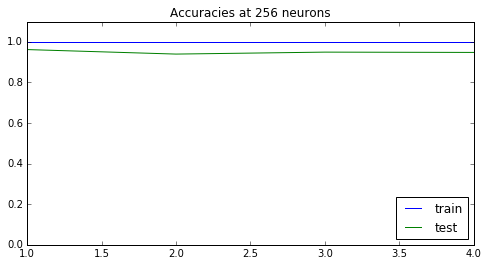

In [8]:
neurons = [8,16,32,64,128,256]

folds = [1,2,3,4]

for n in neurons:
    plt.figure(figsize = (8,4))
    accuracies = cross_validate(features, labels, n)
    plt.title('Accuracies at {} neurons'.format(n))
    plt.plot(folds, accuracies[train], label = 'train')
    plt.plot(folds, accuracies[test], label = 'test')
    plt.ylim(0,1.1)
    plt.legend(loc = 'lower right')
    print("Mean accuracy at {} neurons:".format(n), np.mean(accuracies[test]))
    

## Best Model With One Hidden Layer

The model at 8 neurons is wholely inaccuracte, with very low prediction accuracy. As we increase the number of neurons in the hidden layer it would appear that we achieve higher and higher performance accuracy. At 8 neurons it would seem that there is some underfitting as is illustrated by the low prediction accuracy. There seems to be some instability at neuron counts 16, 32, 64, and 128, although the training error is zero from neuron count 32 and upwards. Although this is the case, it seems that as we increase the neuron count we get more and more prediuction accuracy in the test set - which implies space for improvement. Once we're at 256 neurons there is a tight and stable spread between the training and testing accuracy, it would seem that at this point we have optimized the model.

## Neural Network With Two Hidden Layers

We will now follow the same procedure and create a model with two hidden layers to see if we get increased prediction accuracy. Again we will use 4-fold cross validation. We will be using a two-hidden-layer model with 64 neurons in each layer.

Mean accuracy at (64, 64) neurons: 0.8937130043904578
Mean accuracy at (128, 128) neurons: 0.9020593901383226
Mean accuracy at (256, 256) neurons: 0.9126334981131826


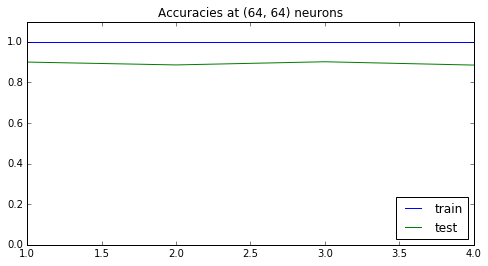

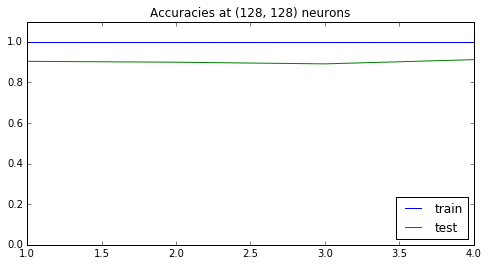

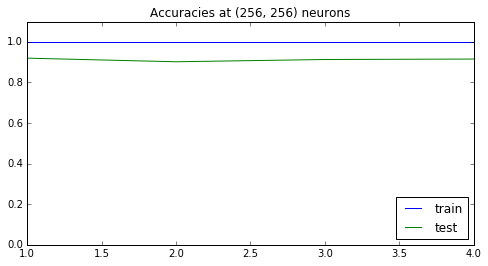

In [9]:
n_neurons = [(64,64), (128,128), (256,256)]

for n in n_neurons:
    plt.figure(figsize = (8,4))
    accuracies = cross_validate(features, labels, n)
    plt.title('Accuracies at {} neurons'.format(n))
    plt.plot(folds, accuracies[train], label = 'train')
    plt.plot(folds, accuracies[test], label = 'test')
    plt.ylim(0,1.1)
    plt.legend(loc = 'lower right')
    print("Mean accuracy at {} neurons:".format(n), np.mean(accuracies[test]))

## Neural Network With Three Hidden Layers

We will once again follows the same procedure as before, except this time we will be using three hidden layers with different neuron counts for each model.

Mean accuracy at (10, 10, 10) neurons: 0.6153134011398007
Mean accuracy at (64, 64, 64) neurons: 0.8601304360277482
Mean accuracy at (128, 128, 128) neurons: 0.8812855361623477
Mean accuracy at (256, 256, 256) neurons: 0.9007628227581239


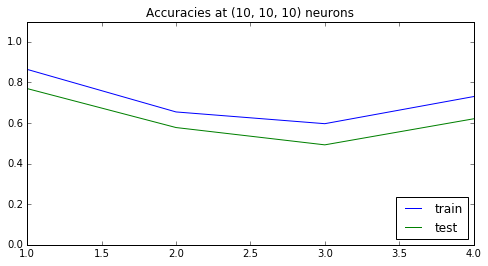

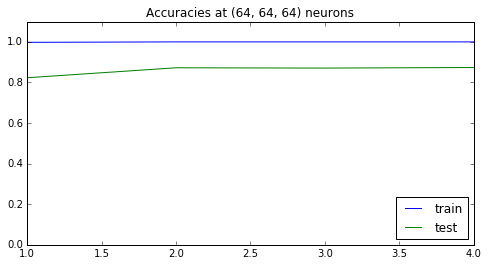

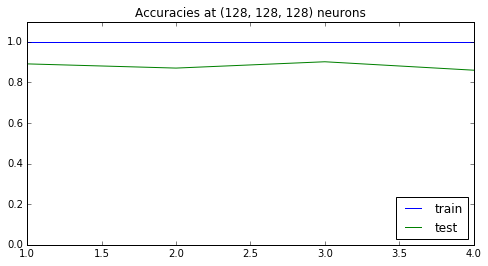

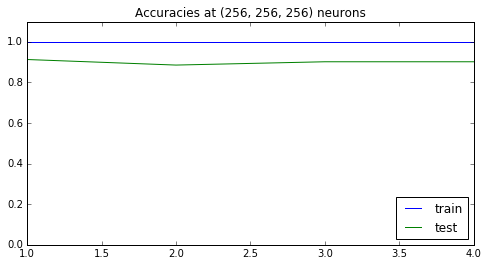

In [10]:
n_neurons = [(10,10,10), (64,64,64), (128,128,128), (256,256,256)]

for n in n_neurons:
    plt.figure(figsize = (8,4))
    accuracies = cross_validate(features, labels, n)
    plt.title('Accuracies at {} neurons'.format(n))
    plt.plot(folds, accuracies[train], label = 'train')
    plt.plot(folds, accuracies[test], label = 'test')
    plt.ylim(0,1.1)
    plt.legend(loc = 'lower right')
    print("Mean accuracy at {} neurons:".format(n), np.mean(accuracies[test]))

## Decision Tree and Random Forrests

We will now attempt to use both a decision tree model and then a Randeom Forrest model to determine if we can get improved accuracy. Once we have done this we can compare the performance of each model in the project.

## Decision Trees

We will model our decision trees based on different values for 'max_depth' to determine at what depoth we achieve the most accurate predictions

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def train(train_features, train_target, max_depth):
    dt = DecisionTreeClassifier(max_depth = max_depth, random_state =1)
    dt.fit(train_features, train_target)
    return dt

def test(model, test_features, test_target):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['actual'] = test_target
    train_test_df['predicted'] = predictions
    test_accuracy = sum(train_test_df['predicted'] == train_test_df['actual'])/len(train_test_df)
    return test_accuracy

def cross_validate(features, target, max_depth):
    accuracies = {}
    validation_accuracies = []
    train_accuracies = []
    kf = KFold(n_splits = 4, shuffle = True, random_state = 1)
    for test_index, train_index in kf.split(features):
        train_features, test_features = features.loc[train_index], features.loc[test_index]
        test_labels, train_labels = target.loc[test_index], target.loc[train_index]
        model = train(train_features, train_labels, max_depth)        
        test_accuracy = test(model, test_features, test_labels)
        train_accuracy = test(model, train_features, train_labels)
        validation_accuracies.append(test_accuracy)
        train_accuracies.append(train_accuracy)
    accuracies[train] = train_accuracies
    accuracies[test] = validation_accuracies
    return accuracies

{5: 0.6421760412742681, 6: 0.7174909514273944, 7: 0.7442036540151871, 8: 0.7468003685517217, 9: 0.7571875020652554, 10: 0.753663763192852, 11: 0.7545923020493943, 12: 0.7540359222274358, 13: 0.7562614415152698, 14: 0.7562614415152698, 15: 0.7562614415152698}

The optimal depth of this decision tree model is 9 which achieves an accuracy score of 0.7571875020652554


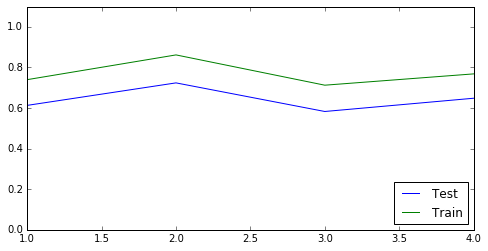

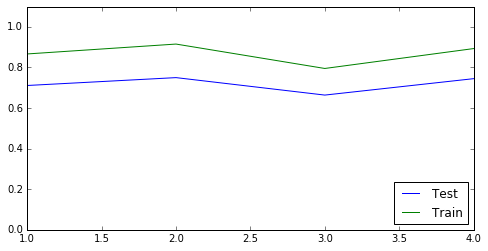

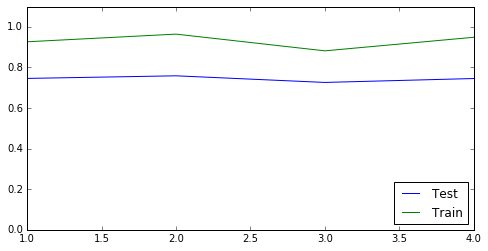

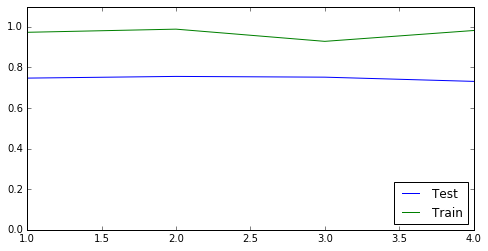

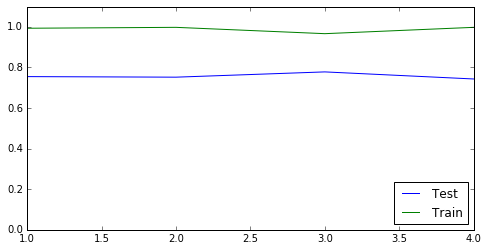

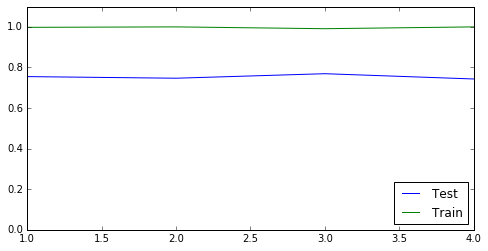

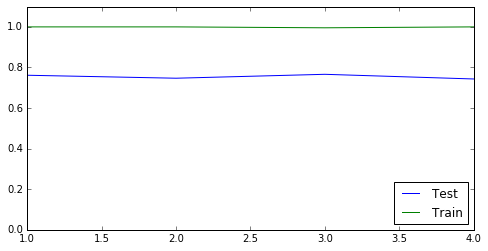

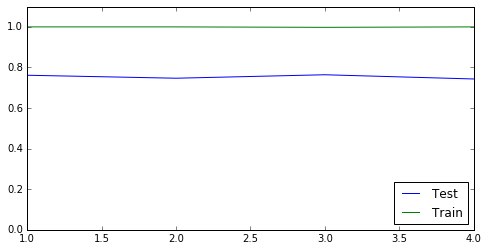

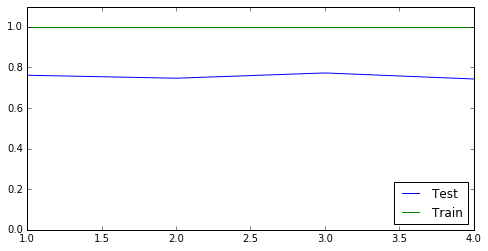

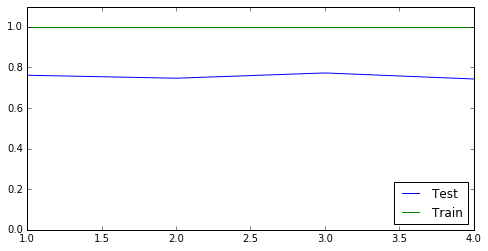

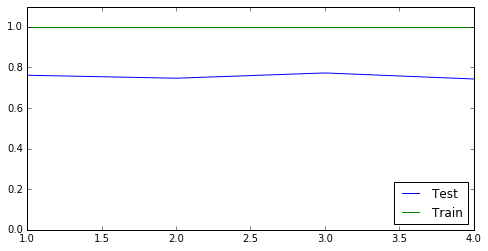

In [39]:
depths = [5,6,7,8,9,10,11,12,13,14,15]
accuracy_by_depth = {}


for d in depths:
    plt.figure(figsize = (8,4))
    accuracies = cross_validate(features, labels, d)
    mean_accuracy = np.mean(accuracies[test])
    accuracy_by_depth[d] = mean_accuracy
    plt.plot(folds, accuracies[test], label = 'Test')
    plt.plot(folds, accuracies[train], label = 'Train')
    plt.legend(loc = 'lower right')
    plt.ylim(0,1.1)
    
print(accuracy_by_depth)
print()

print('The optimal depth of this decision tree model is', max(accuracy_by_depth, key = accuracy_by_depth.get),
     'which achieves an accuracy score of', max(accuracy_by_depth.values()))

## Random Forests

We will model various random forrests at different values for 'n_estimators' to determine at which value of 'n_estimators' we achieve the highest prediction accuracy.

In [43]:
def train(train_features, train_target, n):
    dt = RandomForestClassifier(n_estimators = n, bootstrap = True, random_state =1)
    dt.fit(train_features, train_target)
    return dt

def test(model, test_features, test_target):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['actual'] = test_target
    train_test_df['predicted'] = predictions
    test_accuracy = sum(train_test_df['predicted'] == train_test_df['actual'])/len(train_test_df)
    return test_accuracy

def cross_validate(features, target, n):
    accuracies = {}
    validation_accuracies = []
    train_accuracies = []
    kf = KFold(n_splits = 4, shuffle = True, random_state = 1)
    for test_index, train_index in kf.split(features):
        train_features, test_features = features.loc[train_index], features.loc[test_index]
        test_labels, train_labels = target.loc[test_index], target.loc[train_index]
        model = train(train_features, train_labels, n)        
        test_accuracy = test(model, test_features, test_labels)
        train_accuracy = test(model, train_features, train_labels)
        validation_accuracies.append(test_accuracy)
        train_accuracies.append(train_accuracy)
    accuracies[train] = train_accuracies
    accuracies[test] = validation_accuracies
    return accuracies

{200: 0.9499148013279317, 50: 0.9404534529969886, 100: 0.947132076115954, 150: 0.9469470292263938}

The optimal value for n_estimators of this random forest tree model is 200 which achieves an accuracy score of 0.9499148013279317


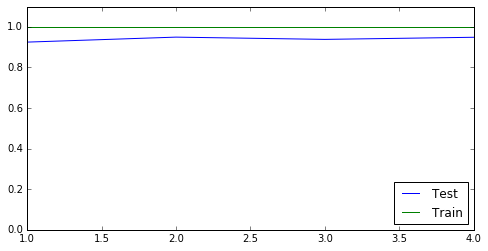

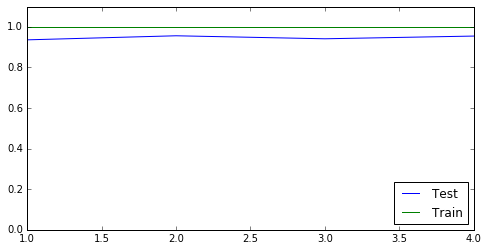

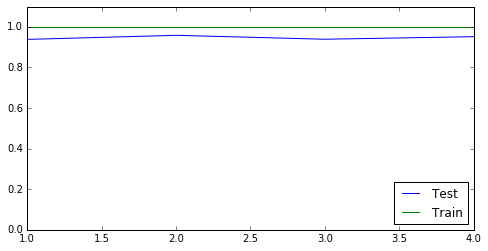

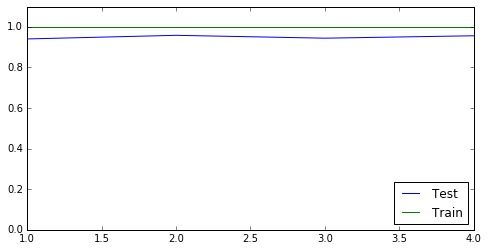

In [45]:
n_estimators_ = [50,100,150,200]
accuracy_by_estimator_count = {}


for n in n_estimators_:
    plt.figure(figsize = (8,4))
    accuracies = cross_validate(features, labels, n)
    mean_accuracy = np.mean(accuracies[test])
    accuracy_by_estimator_count[n] = mean_accuracy
    plt.plot(folds, accuracies[test], label = 'Test')
    plt.plot(folds, accuracies[train], label = 'Train')
    plt.legend(loc = 'lower right')
    plt.ylim(0,1.1)
    
print(accuracy_by_estimator_count)
print()
print('The optimal value for n_estimators of this random forest tree model is', max(accuracy_by_estimator_count, key = accuracy_by_estimator_count.get),
     'which achieves an accuracy score of', max(accuracy_by_estimator_count.values()))

## Results

The results would suggest that, for the data we are using, the most accurate model would be the K-neareswt neighb ours model with a prediction accuracy of about 98.5%. In terms of the neural networks we created, it is apparent that we got diminishing returns in terms of accuracy the more hidden layers we added. It must be stated however, that in terms of the number of neurons in the hidden layers, accuracy was always improved in each specific model (one, two and three hidden layers) when we added more neurons.

The best neural network model was the model with one hidden layer and 256 neurons, achieving an accuracy of just under **95%**. From this point onwards, the best model in each class of neural networks (classed by hidden layers) was significantly less than the accuracy achieved in the model with one hidden layer and 256 neurons - achieving accuracies of **91%** and **90%** in the two hidden layer and three hidden layer models respectively. 

In both the two layer and three layer models we don't seem to ever fit the training data to any optimal point.

On to the Decision Tree models, we saw that optimization occured at a max_depth of **9**, however, the accruacy of this model once optimized was only in the region 75%. Looking at the diagrams it seems that this model overfitted (as one would expect with Decision Tree Models), with an practically **100%** accuracy on the traing data but very poor accuracy on the test data.

Conversely, when runninng the Random Forrest model, we found that it was optimized at a value of 200 for the n_estimators parameter achieving an impressive mean prediction accuracy of just under **95%**. We see that it far outperformed the Decision Tree model, and it appears to generalize quite well to new data (as is evident in the cross_validations), with the test accuracy showiing promise.